In [220]:
import re
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt

from sklearn import model_selection

from sklearn.metrics import confusion_matrix

%matplotlib inline 

### Constants

In [221]:
poolSize = 5000

senior_perc_contr = 0.5
senior_ann_int = 0.03

subordinate_perc_contr = 0.35
subordinate_ann_int = 0.06

equity_perc_contr = 0.15

year = 2014
term = 36

### Load models

In [222]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xgbModel = xgb.Booster({'nthread': 4})  # init model
xgbModel.load_model('xgb_best_model')  # load data

In [223]:
from tensorflow import keras
kerasModel = keras.models.load_model('keras_model')

### Load model results

In [224]:
predicted_good_loan_ids = set()

In [225]:
xgb_results_df = pd.read_csv('all_accept_xgb_df.csv') 

for i in range(len(xgb_results_df)):
    if xgb_results_df.loc[i, "predicted_val"] == 1:
        predicted_good_loan_ids.add(xgb_results_df.loc[i, "id"])

In [226]:
keras_results_df = pd.read_csv('all_accept_keras_df.csv') 

for i in range(len(keras_results_df)):
    if keras_results_df.loc[i, "predicted_val"] == 1:
        predicted_good_loan_ids.add(keras_results_df.loc[i, "id"])

### Data analysis

In [227]:
# all accepted loans from lendingclub
all_accept_df = pd.read_csv('./archive/accepted_2007_to_2018q4.csv')

/Users/kmanda/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [228]:
all_accept_df.shape

(2260701, 151)

In [229]:
all_accept_df = all_accept_df[all_accept_df['id'].isin(predicted_good_loan_ids)]

In [230]:
all_accept_df.shape

(1929988, 151)

In [231]:
# drop invalid loan_status to 'Unknown'

all_accept_df.loc[pd.isnull(all_accept_df['loan_status']),'loan_status'] = 'Unknown'

all_accept_df.loan_status.unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default'], dtype=object)

In [232]:
loan_status = all_accept_df['loan_status']

loan_status[(loan_status=='Fully Paid') | (loan_status=='Current') |
            (loan_status=='Does not meet the credit policy. Status:Fully Paid') |
            (loan_status=='In Grace Period')] = 1

loan_status[loan_status != 1] = 0

all_accept_df['loan_status'] = pd.to_numeric(loan_status)

/Users/kmanda/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/kmanda/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [233]:
# convert column to numeric

all_accept_df['term'] = pd.to_numeric(all_accept_df['term'].apply(lambda x: re.findall(r'\d+', str(x))).str[0])
all_accept_df['deferral_term'] = pd.to_numeric(all_accept_df['deferral_term'])

In [234]:
# filter dataframe by year and term months 
# so as to create pools of poolSize

all_accept_df = all_accept_df[pd.DatetimeIndex(all_accept_df['issue_d']).year == year]
all_accept_df = all_accept_df[all_accept_df['term'] == term]

sampleSize = int(all_accept_df.shape[0] / poolSize) * poolSize

all_accept_df = all_accept_df.sample(sampleSize)

In [235]:
def ConvertDateTimeToOrdinal(d):
    if d is pd.NaT:
        return 0
    else:
        return d.toordinal()

In [236]:
# convert columns to datetime (toordinal)

dateCols = pd.Series(
    ['issue_d',
    'earliest_cr_line',
    'last_pymnt_d',
    'next_pymnt_d',
    'last_credit_pull_d',
    'debt_settlement_flag_date',
    'settlement_date',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'sec_app_earliest_cr_line'])

for col in dateCols:    
    all_accept_df[col] = pd.to_datetime(all_accept_df[col]).apply(ConvertDateTimeToOrdinal)

In [237]:
# drop columns to be ignore for now

all_accept_df = all_accept_df.drop([
    'id',
    'member_id',
    'emp_title',
    'emp_length',
    'home_ownership',
    'url',
    'desc',
    'title',
    'zip_code',
    'addr_state',
    'initial_list_status',
    'verification_status_joint',  
    'hardship_type',
    'hardship_reason',
    'disbursement_method'
], axis=1)

In [238]:
# Dummify

colsToBeDummified = pd.Series(
    ['grade',
    'sub_grade',
    'verification_status',
    'purpose',
    'pymnt_plan',
    'application_type',
    'hardship_flag',
    'hardship_status',
    'hardship_loan_status',
    'debt_settlement_flag',
    'settlement_status'])

for col in colsToBeDummified:    
    all_accept_df = all_accept_df.join(pd.get_dummies(all_accept_df[col], drop_first=True, prefix=col))
    all_accept_df = all_accept_df.drop(col, axis=1)

In [239]:
# handle na

all_accept_df.fillna(0, inplace=True)

In [240]:
# make sure all columns are numeric

for col in all_accept_df.columns:
    all_accept_df[col] = pd.to_numeric(all_accept_df[col])

In [241]:
all_accept_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140000 entries, 1147126 to 1165484
Columns: 186 entries, loan_amnt to settlement_status_COMPLETE
dtypes: float64(112), int64(13), uint8(61)
memory usage: 147.7 MB


### Define function to evaluate tranche returns for pools

In [242]:
def evaluatePools(pools):
    total_loan_amnts = []
    avg_int_rate = []
    avg_dti = []
    avg_fico_range_low = []
    avg_fico_range_high = []
    total_pymnts = []
    total_rec_prncp = []
    total_rec_int = []

    senior_init_pymt = []
    senior_total_pymt = []
    senior_int = []

    subordinate_init_pymt = []
    subordinate_total_pymt = []
    subordinate_int = []

    equity_init_pymt = []
    equity_total_pymt = []
    equity_int = []

    total_calc_pymnts = []
    
    for pool in pools:
        total_loan_amnt = np.sum(pool['loan_amnt'])
        total_pymt = np.sum(pool['total_pymnt'])
        
        total_loan_amnts.append(total_loan_amnt)
        avg_int_rate.append(np.mean(pool['int_rate']))
        avg_dti.append(np.mean(pool['dti']))
        avg_fico_range_low.append(np.mean(pool['fico_range_low']))
        avg_fico_range_high.append(np.mean(pool['fico_range_high']))
        total_pymnts.append(total_pymt)
        total_rec_prncp.append(np.sum(pool['total_rec_prncp']))
        total_rec_int.append(np.sum(pool['total_rec_int']))

        #senior tranche
        init_pymt = senior_perc_contr*total_loan_amnt
        senior_init_pymt.append(init_pymt)

        total_sen_pymt = np.pmt(senior_ann_int/12, term, -senior_perc_contr*total_loan_amnt) * term
        senior_total_pymt.append(total_sen_pymt)

        if total_sen_pymt < total_pymt:
            senior_int.append(senior_ann_int * 100)
        else:
            int_approx = np.rate(term, total_pymt / term, -init_pymt, 0) * 12 * 100
            senior_int.append(int_approx)

        #subordinate tranche
        init_pymt = subordinate_perc_contr*total_loan_amnt
        subordinate_init_pymt.append(init_pymt)

        total_subordinate_pymt = np.pmt(subordinate_ann_int/12, term, -subordinate_perc_contr*total_loan_amnt) * term
        subordinate_total_pymt.append(total_subordinate_pymt)

        if (total_sen_pymt + total_subordinate_pymt) < total_pymt:
            subordinate_int.append(subordinate_ann_int * 100)
        else:
            int_approx = np.rate(term, (total_pymt - total_sen_pymt) / term, -init_pymt, 0) * 12 * 100
            subordinate_int.append(int_approx)

        #equity tranche
        init_pymt = equity_perc_contr*total_loan_amnt
        equity_init_pymt.append(init_pymt)

        total_equity_pymt = total_pymt - total_sen_pymt - total_subordinate_pymt
        equity_total_pymt.append(total_equity_pymt)

        int_approx = np.rate(36, 0, -init_pymt, total_equity_pymt) * 12 * 100
        equity_int.append(int_approx)

        #total calculated payments
        total_calc_pymnts.append(total_sen_pymt+total_subordinate_pymt+total_equity_pymt)
    
    #create results data frame
    list_of_tuples = list(zip(total_loan_amnts, avg_int_rate, avg_dti, avg_fico_range_low, avg_fico_range_high, total_pymnts, total_rec_prncp, total_rec_int, senior_init_pymt, senior_total_pymt, senior_int, subordinate_init_pymt, subordinate_total_pymt, subordinate_int, equity_init_pymt, equity_total_pymt, equity_int, total_calc_pymnts))

    pool_results_df = pd.DataFrame(list_of_tuples,
                                  columns = ['total_loan_amnts', 'avg_int_rate', 'avg_dti', 'avg_fico_range_low', 'avg_fico_range_high', 'total_pymnts', 'total_rec_prncp', 'total_rec_int', 'senior_init_pymt', 'senior_total_pymt', 'senior_int', 'subordinate_init_pymt', 'subordinate_total_pymt', 'subordinate_int', 'equity_init_pymt', 'equity_total_pymt', 'equity_int', 'total_calc_pymnts'])

    return(pool_results_df)

### Evaluate performance of randomly created pools

In [243]:
i=0
pools = []

while i < all_accept_df.shape[0]:
    pools.append(pd.DataFrame(all_accept_df[i:i+poolSize]))
    i = i + poolSize
    
pool_results_df = evaluatePools(pools)

print(pool_results_df.shape)
pool_results_df.head()

(28, 18)


/Users/kmanda/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: numpy.pmt is deprecated and will be removed from NumPy 1.20. Use numpy_financial.pmt instead (https://pypi.org/project/numpy-financial/).
/Users/kmanda/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: numpy.pmt is deprecated and will be removed from NumPy 1.20. Use numpy_financial.pmt instead (https://pypi.org/project/numpy-financial/).
/Users/kmanda/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: numpy.rate is deprecated and will be removed from NumPy 1.20. Use numpy_financial.rate instead (https://pypi.org/project/numpy-financial/).


,total_loan_amnts,avg_int_rate,avg_dti,avg_fico_range_low,avg_fico_range_high,total_pymnts,total_rec_prncp,total_rec_int,senior_init_pymt,senior_total_pymt,senior_int,subordinate_init_pymt,subordinate_total_pymt,subordinate_int,equity_init_pymt,equity_total_pymt,equity_int,total_calc_pymnts
0,64126700.0,12.157738,17.268876,693.987,697.9870,7.401387e+07,64036484.38,9937567.37,32063350.0,3.356788e+07,3.0,22444345.00,2.458082e+07,6.0,9619005.00,1.586518e+07,16.795987,7.401387e+07
1,64600550.0,12.128360,16.999706,693.795,697.7952,7.467593e+07,64486967.40,10113307.57,32300275.0,3.381592e+07,3.0,22610192.50,2.476245e+07,6.0,9690082.50,1.609756e+07,17.038651,7.467593e+07
2,63211125.0,12.197334,17.277350,693.640,697.6400,7.309885e+07,63113272.30,9915038.15,31605562.5,3.308861e+07,3.0,22123893.75,2.422986e+07,6.0,9481668.75,1.578038e+07,17.100950,7.309885e+07
3,62276400.0,12.245342,17.408622,693.283,697.2830,7.207163e+07,62142670.37,9837313.22,31138200.0,3.259931e+07,3.0,21796740.00,2.387157e+07,6.0,9341460.00,1.560075e+07,17.217566,7.207163e+07
4,62134300.0,12.127230,17.262820,694.377,698.3770,7.189919e+07,62003570.49,9818404.62,31067150.0,3.252493e+07,3.0,21747005.00,2.381710e+07,6.0,9320145.00,1.555716e+07,17.200203,7.189919e+07


### Data visualization

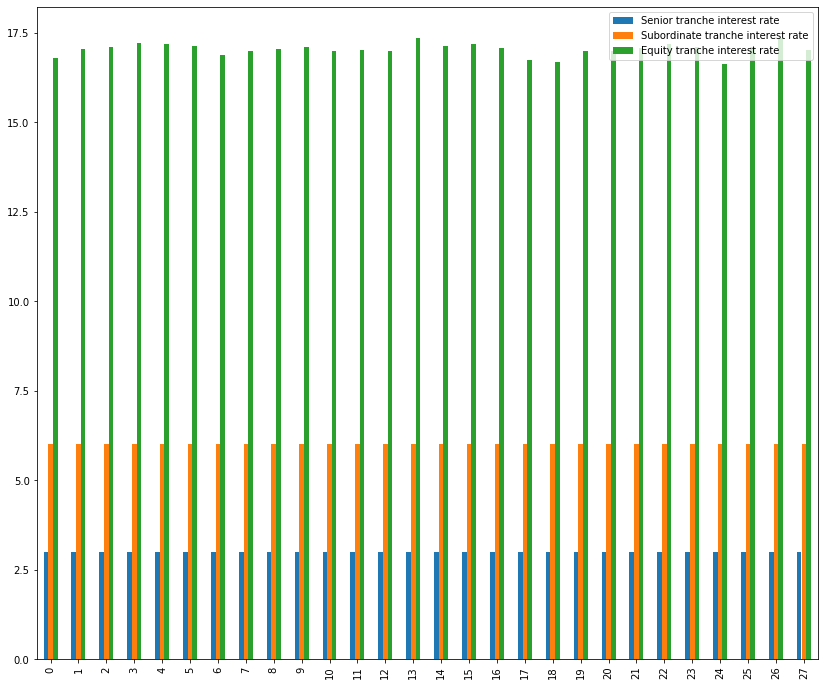

In [244]:
plt = pool_results_df.plot(y=["senior_int", "subordinate_int", "equity_int"], kind="bar", figsize=(14, 12))
plt.legend(["Senior tranche interest rate", "Subordinate tranche interest rate", "Equity tranche interest rate"])
